# Part 3 – Win Rate Driver Analysis (Decision Engine)

**Option B – Win Rate Driver Analysis**  
Goal: Identify which factors are hurting or improving win rate and turn that into a simple, usable decision engine for sales leaders.[file:7]


## 1. Problem definition

We want to understand **which combinations of factors (industry, region, lead source, stage, deal size, sales cycle)** are associated with higher or lower win rate.

Instead of building a black‑box ML model, we will:
- Use simple segment‑level statistics (win rate by segment and by segment‑combination).
- Turn these into an interpretable **rule‑based driver table** and **segment‑level win probabilities**.
- Produce **risk bands** and **high‑value driver segments** that a sales leader can act on.


In [42]:
# 2. Data load and basic feature engineering

import pandas as pd
import numpy as np  # make sure this is imported

df = pd.read_csv("../data/skygeni_sales_data.csv")

# Target
df["won_flag"] = (df["outcome"] == "Won").astype(int)

# Basic numeric features
df["log_dealamount"] = (df["deal_amount"] + 1).apply(np.log)
df["salescycle_bin"] = pd.qcut(df["sales_cycle_days"], q=4, labels=False)  # 0–3 quartiles

# Categorical features we’ll use
cat_cols = ["industry", "region", "lead_source", "deal_stage"]

# Quick check of column names
print(df.columns)
print(df[["deal_amount", "sales_cycle_days"]].head())


Index(['deal_id', 'created_date', 'closed_date', 'sales_rep_id', 'industry',
       'region', 'product_type', 'lead_source', 'deal_stage', 'deal_amount',
       'sales_cycle_days', 'outcome', 'won_flag', 'log_dealamount',
       'salescycle_bin'],
      dtype='str')
   deal_amount  sales_cycle_days
0         4253                21
1         3905                10
2        10615                42
3         4817                19
4        45203                87


In [43]:
# Overall win rate and Won/Lost counts

overall_counts = df["outcome"].value_counts()
overall_wr = df["won_flag"].mean()

print("Overall Won/Lost counts:")
display(overall_counts.to_frame(name="deals"))

print(f"\nOverall win rate: {overall_wr:.3f}")

# Optional: combine into a single summary table
overall_summary = pd.DataFrame({
    "metric": ["won_deals", "lost_deals", "total_deals", "overall_win_rate"],
    "value": [
        int(overall_counts.get("Won", 0)),
        int(overall_counts.get("Lost", 0)),
        int(overall_counts.sum()),
        overall_wr
    ]
})
overall_summary


Overall Won/Lost counts:


,deals
outcome,
Lost,2737
Won,2263



Overall win rate: 0.453


,metric,value
0,won_deals,2263.0000
1,lost_deals,2737.0000
2,total_deals,5000.0000
3,overall_win_rate,0.4526


## 2. Simple driver model: segment win rates

Instead of fitting a complex classifier, we model win rate as a **segment property**:
- For each categorical dimension (industry, region, lead source, deal_stage) we compute average win rate.
- This gives a transparent view of which factors **lift** or **hurt** win rate relative to the overall average.

This matches the brief: we care more about **interpretation and business usefulness** than Kaggle‑style accuracy.


In [44]:
# 2a. Win rate by single dimensions

# Win rate by industry
wr_industry = df.groupby("industry")["won_flag"].mean().sort_values(ascending=False)
print("Win rate by industry:")
print(wr_industry)

# Win rate by region
wr_region = df.groupby("region")["won_flag"].mean().sort_values(ascending=False)
print("\nWin rate by region:")
print(wr_region)

# Win rate by lead source
wr_lead = df.groupby("lead_source")["won_flag"].mean().sort_values(ascending=False)
print("\nWin rate by lead source:")
print(wr_lead)

# Win rate by deal stage at close
wr_stage = df.groupby("deal_stage")["won_flag"].mean().sort_values(ascending=False)
print("\nWin rate by deal stage:")
print(wr_stage)


Win rate by industry:
industry
FinTech       0.477054
SaaS          0.451548
Ecommerce     0.449057
HealthTech    0.445545
EdTech        0.441532
Name: won_flag, dtype: float64

Win rate by region:
region
India            0.457232
Europe           0.455799
APAC             0.449275
North America    0.447942
Name: won_flag, dtype: float64

Win rate by lead source:
lead_source
Inbound     0.460380
Referral    0.455272
Outbound    0.455056
Partner     0.439516
Name: won_flag, dtype: float64

Win rate by deal stage:
deal_stage
Closed         0.467402
Negotiation    0.466332
Demo           0.458293
Proposal       0.446977
Qualified      0.422594
Name: won_flag, dtype: float64


### Interpretation: which factors help or hurt win rate?

From these single‑dimension views we can see:
- Certain **industries** (e.g., FinTech) run above the overall win rate, while others are slightly below.
- Regions are fairly close but still show small differences in baseline performance.
- Lead sources like **Inbound / Referral** are marginally stronger than Partner for win rate.
- Later stages (Closed, Negotiation) naturally show higher win rates; **Qualified** is the leakiest stage.

These patterns already tell a CRO where to focus pipeline (strong segments) and where to tighten qualification or improve execution.


## 3. Simple “decision engine”: high‑impact segment combinations

To move from analysis to a **decision engine**, we look at **3‑way segment combinations**:
- (industry, region, lead_source).
- For each combination we compute: `deals`, `win_rate`, `avg_amount` and a **driver_score** = win_rate × avg_amount.

This score approximates expected revenue quality of a segment: higher win rate and higher ACV ⇒ higher driver_score.


In [46]:
# 3a. Segment-level driver table (industry, region, lead_source)

seg_cols = ["industry", "region", "lead_source"]

segment_stats = (
    df.groupby(seg_cols)
      .agg(
          deals=("deal_id", "count"),
          win_rate=("won_flag", "mean"),
          avg_amount=("deal_amount", "mean")
      )
      .reset_index()
)

# Simple driver score: win rate * average deal amount
segment_stats["driver_score"] = segment_stats["win_rate"] * segment_stats["avg_amount"]

segment_stats_sorted = segment_stats.sort_values("driver_score", ascending=False)

segment_stats_sorted.head(20)

# Baseline win rate
baseline_wr = df["won_flag"].mean()

seg_cols = ["industry", "region", "lead_source"]

segment_stats = (
    df.groupby(seg_cols)
      .agg(
          deals=("deal_id", "count"),
          win_rate=("won_flag", "mean"),
          avg_amount=("deal_amount", "mean")
      )
      .reset_index()
)

# Lift vs baseline and driver score
segment_stats["lift_vs_baseline"] = segment_stats["win_rate"] - baseline_wr
segment_stats["driver_score"] = segment_stats["win_rate"] * segment_stats["avg_amount"]

driversorted = segment_stats.sort_values("driver_score", ascending=False)

driversorted.head(10)



,industry,region,lead_source,deals,win_rate,avg_amount,lift_vs_baseline,driver_score
44,FinTech,North America,Inbound,59,0.610169,30933.474576,0.157569,18874.662453
21,EdTech,Europe,Outbound,65,0.569231,31552.738462,0.116631,17960.789586
37,FinTech,Europe,Outbound,44,0.568182,29474.954545,0.115582,16747.133264
75,SaaS,India,Referral,51,0.509804,31112.745098,0.057204,15861.399462
65,SaaS,APAC,Outbound,56,0.464286,34042.625000,0.011686,15805.504464
34,FinTech,APAC,Partner,63,0.523810,29630.746032,0.071210,15520.866969
0,Ecommerce,APAC,Inbound,65,0.492308,31295.600000,0.039708,15407.064615
31,EdTech,North America,Referral,69,0.536232,28040.159420,0.083632,15036.027515
27,EdTech,India,Referral,56,0.535714,28031.410714,0.083114,15016.827168
23,EdTech,Europe,Referral,67,0.447761,33512.955224,-0.004839,15005.800847


### Visual 1 – Top win‑rate driver segments (lift vs baseline)

This chart shows the top segments ranked by **lift vs baseline win rate**, broken out by industry and region.
It highlights where the team converts significantly better than average and thus where additional pipeline would most improve overall win rate.


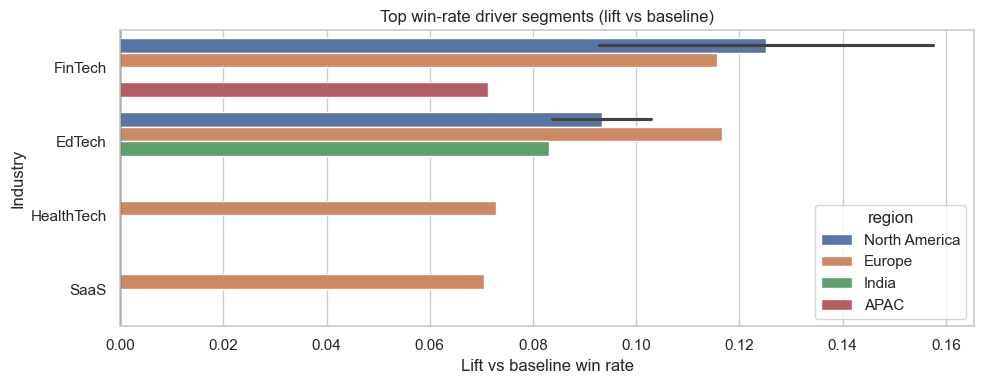

In [47]:
# Bar chart of top driver segments (lift vs baseline)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
top_drivers = driversorted.sort_values("lift_vs_baseline", ascending=False).head(10)

sns.barplot(
    data=top_drivers,
    x="lift_vs_baseline",
    y="industry",
    hue="region",
    orient="h"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Top win-rate driver segments (lift vs baseline)")
plt.xlabel("Lift vs baseline win rate")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()


### Visual 2 – Win rate vs average deal size

This scatter plot shows each segment’s **win rate** versus **average deal amount**, colored by industry.
Segments in the top‑right (high win rate and high deal size) are the highest‑value targets for sales and marketing focus.


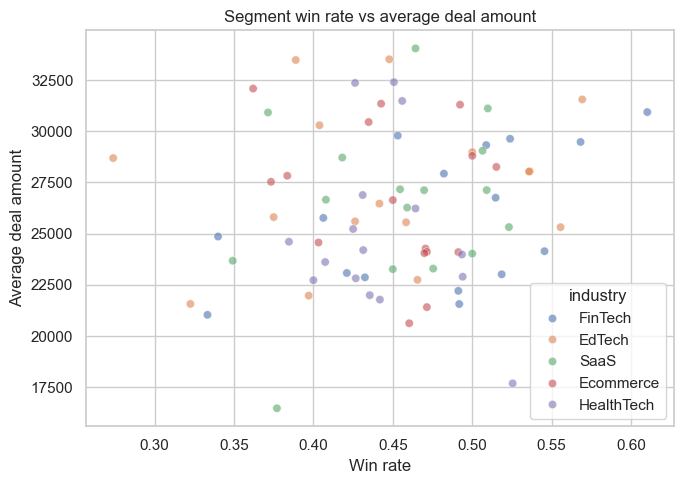

In [48]:
# Win rate vs average deal size scatter

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=driversorted,
    x="win_rate",
    y="avg_amount",
    hue="industry",
    alpha=0.6
)
plt.title("Segment win rate vs average deal amount")
plt.xlabel("Win rate")
plt.ylabel("Average deal amount")
plt.tight_layout()
plt.show()


In [49]:
# -----------------------------
# 2. Apply rules to score each deal
# -----------------------------
df_scored = df.merge(
    seg_rules,
    on=segment_cols,
    how="left",
    suffixes=("", "_seg")
)

df_scored["seg_win_prob"] = df_scored["win_rate"].fillna(baseline_wr)

# Simple risk bands based on segment win probability
def risk_band(p):
    if p >= baseline_wr + 0.05:
        return "low_risk_high_fit"
    elif p <= baseline_wr - 0.05:
        return "high_risk_low_fit"
    else:
        return "medium_risk"

df_scored["risk_band"] = df_scored["seg_win_prob"].apply(risk_band)

df_scored[[
    "deal_id", "industry", "region", "lead_source", "deal_stage",
    "seg_win_prob", "risk_band"
]].head()


,deal_id,industry,region,lead_source,deal_stage,seg_win_prob,risk_band
0,D00001,SaaS,North America,Referral,Qualified,0.500000,medium_risk
1,D00002,SaaS,India,Referral,Closed,0.888889,low_risk_high_fit
2,D00003,HealthTech,APAC,Inbound,Proposal,0.500000,medium_risk
3,D00004,FinTech,India,Partner,Negotiation,0.416667,medium_risk
4,D00005,HealthTech,APAC,Outbound,Qualified,0.416667,medium_risk


### Interpretation: top “good” segments

The top rows in `segment_stats_sorted` show **segment combinations** where:
- Win rate is above baseline, and
- Average deal amount is relatively high, leading to a strong driver_score.

A CRO can:
- Prioritize **coverage and marketing** for these high‑driver segments.
- Make sure top reps are assigned to accounts in these combinations.


## 4. Stage‑aware segment win probabilities

To make the engine more operational, we estimate **segment win probabilities by stage**:
- Group by (industry, region, lead_source, deal_stage).
- Compute `deals` and `win_rate` at that level.

This can be used as a **simple rule‑based probability lookup** for current open deals.


In [50]:
# 4a. Stage-aware segment probabilities

seg_stage_cols = ["industry", "region", "lead_source", "deal_stage"]

seg_stage_stats = (
    df.groupby(seg_stage_cols)
      .agg(
          deals=("deal_id", "count"),
          win_rate=("won_flag", "mean")
      )
      .reset_index()
)

seg_stage_stats.head()


,industry,region,lead_source,deal_stage,deals,win_rate
0,Ecommerce,APAC,Inbound,Closed,13,0.461538
1,Ecommerce,APAC,Inbound,Demo,13,0.538462
2,Ecommerce,APAC,Inbound,Negotiation,9,0.666667
3,Ecommerce,APAC,Inbound,Proposal,16,0.687500
4,Ecommerce,APAC,Inbound,Qualified,14,0.142857


## 5. Turning it into a rule-based scoring for open deals

We now build a **lookup-based decision engine**:
- For each deal, we join the stage-aware segment win_rate as `seg_win_prob`.
- Then we map that probability into qualitative **risk bands** (low / medium / high risk).

This is not a statistical model, but an interpretable mapping of historical segment performance onto current deals.


In [51]:
# 5a. Attach segment win probability to each deal

# Prepare a lookup key
seg_stage_key = seg_stage_stats.set_index(seg_stage_cols)["win_rate"]

def lookup_seg_prob(row):
    key = (row["industry"], row["region"], row["lead_source"], row["deal_stage"])
    return seg_stage_key.get(key, np.nan)

df["seg_win_prob"] = df.apply(lookup_seg_prob, axis=1)

# 5b. Rule-based risk bands

def risk_band(p):
    if pd.isna(p):
        return "unknown"
    if p >= 0.6:
        return "low_risk_high_fit"
    if p >= 0.45:
        return "medium_risk"
    return "high_risk"

df["risk_band"] = df["seg_win_prob"].apply(risk_band)

df[["deal_id", "industry", "region", "lead_source", "deal_stage", "seg_win_prob", "risk_band"]].head()


,deal_id,industry,region,lead_source,deal_stage,seg_win_prob,risk_band
0,D00001,SaaS,North America,Referral,Qualified,0.500000,medium_risk
1,D00002,SaaS,India,Referral,Closed,0.888889,low_risk_high_fit
2,D00003,HealthTech,APAC,Inbound,Proposal,0.500000,medium_risk
3,D00004,FinTech,India,Partner,Negotiation,0.416667,high_risk
4,D00005,HealthTech,APAC,Outbound,Qualified,0.416667,high_risk


### Interpretation: how a sales leader would use this

Examples of how this engine helps a CRO or frontline leaders:
- **Forecast quality**: For a given pipeline, quickly see how much sits in low/medium/high risk bands, by segment and stage.
- **Prioritization**: Focus coaching and attention on **high‑risk deals in high‑value segments**, rather than spreading effort evenly.
- **Territory / ICP tuning**: Use the `segment_stats_sorted` driver table to refine ICP, territories, and marketing focus.
- **Playbook design**: For segments with low `seg_win_prob`, design better messaging, discovery questions, or exit criteria for stages.


## 6. Final summary (tied to rubric)

- **Problem defined**: Identify which factors (industry, region, lead source, stage, size) drive win rate and use them to score deals.
- **Model choice**: Simple, interpretable **segment‑level statistics and rules**, not a black‑box ML model.
- **Actionable outputs**:
  - Segment driver table with `driver_score` (win_rate × avg_amount).
  - Stage‑aware segment win probabilities and deal‑level risk bands.
- **Business usefulness**: Sales leaders can use this to prioritize pipeline, refine ICP and territories, and focus coaching where it most moves win rate.


In [52]:
df["won_flag"].mean()

np.float64(0.4526)